In [47]:
import numpy

class matrix_factorization_learning_model():
    
    def __init__(self,R,a,b,it,k,r):
        self.R=R
        self.user_n, self.item_n=R.shape
        self.alpha=a
        self.beta=b
        self.iterations=it
        self.K=k
        self.random=r
        self.committee=False
        
    def setCommittee(self,C):
        self.C=C
        self.committee=True
        
        
    def learn(self):
        self.b_users=numpy.zeros(self.user_n)
        self.b_items=numpy.zeros(self.item_n)
        self.b=numpy.mean(self.R[numpy.where(self.R!=0)])
        
        self.P=numpy.random.normal(scale=1./self.K,size=(self.user_n,self.K))
        self.Q=numpy.random.normal(scale=1./self.K,size=(self.item_n,self.K))
        rng=numpy.random.default_rng()
        
        self.values=numpy.empty((self.R.size,3),numpy.int8)
        k=0
        for i in range (self.user_n):
            for j in range (self.item_n):
                if ((self.R[i][j])!=0):
                    self.values[k]=[i,j,self.R[i][j]]
                k+=1
                
        samplesize=5
        self.samples=rng.choice(self.values,samplesize,False)
        
        
        self.notsampled=numpy.empty((0,3),numpy.int8)
        for row in self.values:
            if(not (any(numpy.array_equal(x,row) for x in self.samples))):
                self.notsampled=numpy.append(self.notsampled,[row],0)
        
        training_process=[]
        if ( not (self.random)):
            for i in range (self.iterations):
                self.sgd()
                error=self.mse()
                training_process.append((i, error))
                if not (self.committee):
                    ls=self.leastCertain()
                else:
                    for model in self.C:
                        model.samples=self.samples
                        model.notsampled=self.notsampled
                        model.sgd()
                    ls=voting(C)
                ns=numpy.empty((0,3),numpy.int8)
                for point in self.notsampled:
                    if (point[0]==ls[0] and point[1]==ls[1]):
                        self.samples=numpy.append(self.samples,[point],0)
                        ns=numpy.empty((0,3),numpy.int8)
                        for item in self.notsampled:
                            if (not(numpy.all(item==point))):
                                ns=numpy.append(ns,[item],0)
                    break
                if (ns.size>0):
                    self.notsampled=ns
        else:
            for i in range (self.iterations):
                self.sgd()
                p=numpy.random.randint(self.notsampled.shape[0], size=1)
                self.samples=numpy.append(self.samples,self.notsampled[p],0)
                self.notsampled=numpy.delete(self.notsampled,p,0)
                error=self.mse()
                training_process.append((i, error))
        
        return training_process
    
    def mse(self):
        prediction=self.complete()
        e=0
        for i, j , r in self.samples:
            e+=pow(r-prediction[i][j],2)
        return numpy.sqrt(e)
    
    def leastCertain(self):
        Q=numpy.absolute(self.complete())
        return numpy.unravel_index(numpy.argmin(Q),Q.shape)

    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.b_users[i]+self.b_items[j]+self.b+self.P[i,:].dot(self.Q[j,:].T)
            e = (r - prediction)
            
            
            self.b_users[i]+=self.alpha*(e-self.beta*self.b_users[i])
            self.b_items[j]+=self.alpha*(e-self.beta*self.b_items[j])
            
            self.P[i,:]+=self.alpha*(e*self.Q[j,:]-self.beta*self.P[i,:])
            self.Q[j,:]+=self.alpha*(e*self.P[i,:]-self.beta*self.Q[j,:])
            
    def get_rating(self,i,j):
        return self.b_users[i]+self.b_items[j]+self.b+self.P[i,:].dot(self.Q[j,:].T)
    
    def complete(self):
        return self.P.dot(self.Q.T)+self.b+self.b_users[:,numpy.newaxis]+self.b_items[numpy.newaxis,:]
    
def voting(C):
    D=numpy.zeros(shape=C[0].R.shape)
    for i in range (D.shape[0]):
        for j in range (D.shape[1]):
            vn=0
            vp=0
            for item in C:
                if (item.complete()[i][j]>0):
                    vp+=1
                else:
                    vn+=1
            if (vp==0 or vn==0):
                s1=0
                s2=0
            else:
                s1=vp/len(C)*numpy.log(vp/len(C))
                s2=vn/len(C)*numpy.log(vn/len(C))
            D[i][j]=-s1-s2

    return numpy.unravel_index(numpy.argmax(D),D.shape)
    
def twoWayVoting(C):
    c1=C[0].complete()
    c2=C[1].complete()
    D=numpy.absolute(numpy.subtract(c1,c2))
    print(numpy.unravel_index(numpy.argmax(D),D.shape))
    return numpy.amax(D)
    
        
        

In [58]:
M = numpy.array([
    [1, -1, 1, 1],
    [1, 1, -1, 1],
    [-1, -1, 1, 1],
    [1, 1, 1, -1],
    [1, 1, -1, -1],
])

modelrand = matrix_factorization_learning_model(M, 0.1, 0.01, 10, 2,True)
modelactive = matrix_factorization_learning_model(M, 0.1, 0.01, 10, 2,False)
randlearn=modelrand.learn()
activelearn=modelactive.learn()

In [69]:
C=[]

for i in range(5):
    model = matrix_factorization_learning_model(M, 0.1, 0.01, 4, 2,False)
    model.learn()
    C.append(model)
for i in range(5):
    model = matrix_factorization_learning_model(M, 0.1, 0.01, 4, 2,False)
    model.learn()
    C.append(model)

modelcom = matrix_factorization_learning_model(M, 0.1, 0.01, 10, 2,False)
modelcom.setCommittee(C)
comlearn=modelcom.learn()

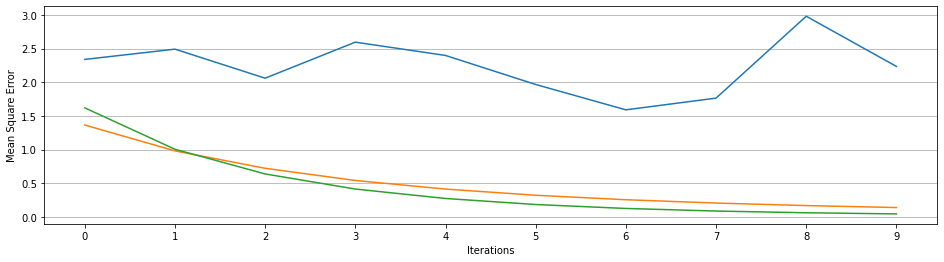

In [70]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

x = [x for x, y in randlearn]
y = [y for x, y in randlearn]
z = [z for z, v in activelearn]
v = [v for z, v in activelearn]
w = [w for w, p in comlearn]
p = [p for w, p in comlearn]
plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.plot(z,v)
plt.plot(w,p)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.grid(axis="y")

In [55]:
M = numpy.array([
    [1, -1, 1, 1],
    [1, 1, -1, 1],
    [-1, -1, 1, 1],
    [1, 1, 1, -1],
    [1, 1, -1, -1],
])
print(M)
print()
C=[]
print("Least Certain Instance's Indexes by models: ")
for i in range(5):
    model = matrix_factorization_learning_model(M, 0.1, 0.01, 25, 2)
    model.learn()
    print(model.leastCertain())
    C.append(model)
for i in range(5):
    model = matrix_factorization_learning_model(M, 0.1, 0.01, 15, 2)
    model.learn()
    print(model.leastCertain())
    C.append(model)

print("\nIndex of the least agreed instance by committee:")
d=voting(C)
print(d)
C=numpy.reshape(C,(2,5))
print("\nBiggest differnce in two models:")
twoWayVoting(C.reshape(10,order='F'))





[[ 1 -1  1  1]
 [ 1  1 -1  1]
 [-1 -1  1  1]
 [ 1  1  1 -1]
 [ 1  1 -1 -1]]

Least Certain Instance's Indexes by models: 


TypeError: __init__() missing 1 required positional argument: 'r'